In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [ ]:
data = loadmat('data/007.mat')
#[[[1500...], [1500...], [1500...], [1500...]]] 
print(data['val'].shape)
sr = 360

In [ ]:
for i in data['val'][0]:
    plt.figure(figsize=(10, 4))
    plt.plot(i)
plt.show()

In [2]:
import numpy as np
from sklearn.decomposition import FastICA

def performICA(data, heartbeats_only=True):
    heartbeats = []
    ica = FastICA(n_components=4)
    data = data.T
    components = ica.fit_transform(data)
    for i in range(4):
        component = components[:, i]
        if np.min(component) < -2: component *= -1
        if np.max(component) > 5: heartbeats.append(component)
        if not heartbeats_only and np.max(component) <= 5: heartbeats.append(5)
    return heartbeats

In [31]:
file_range = range(50, 100)
all_heartbeats = []
for i in file_range:
    filename = f'{i}'.zfill(3)
    data = loadmat(f'data/{filename}.mat')
    data_matrix = np.array(data['val'][0])
    heartbeats = performICA(data_matrix)
    for h in heartbeats:
        all_heartbeats.append(h)

600 0.04082736781323811


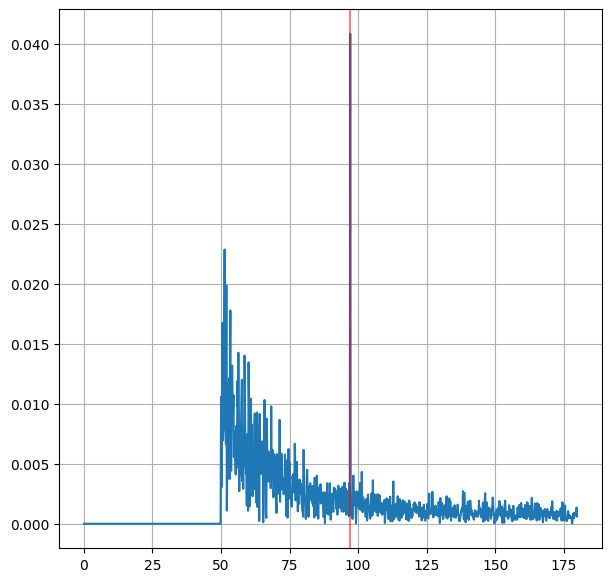

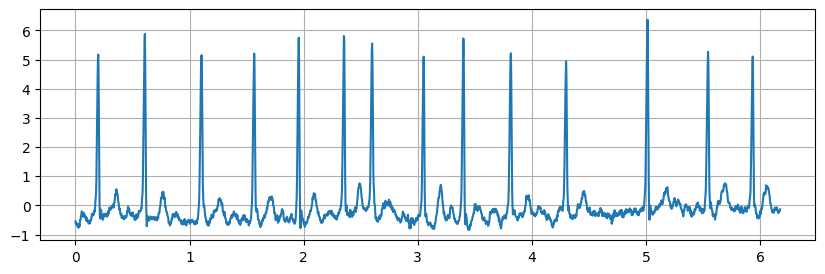

In [97]:
from scipy.fft import fft, fftfreq

for heartbeat in all_heartbeats[10:11]:
    sr = 360
    N = len(heartbeat)
    T = 1 / sr
    yf = fft(heartbeat)
    xf = fftfreq(N, T)[:N//2]

    hz = 2.0/N * np.abs(yf[0:N//2])
    for i in range(len(hz)):
        if xf[i] > 50: break
        hz[i] = 0
    print(np.argmax(hz), np.max(hz))
    plt.figure(figsize=(7, 7))
    plt.plot(xf, hz)
    plt.axvline(xf[np.argmax(hz)], c='r', alpha=0.5)
    plt.grid()
    plt.figure(figsize=(10, 3))
    plt.plot(np.arange(0, len(heartbeat)/sr, 1/sr), heartbeat)
    plt.grid()
    plt.show()
    break
